<a href="https://colab.research.google.com/github/DEli-26/DS_Practicum/blob/main/11_boosting/deli_proj_pract_11_boosting_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=6><b>**Я.Практикум. Проект №11**</b></font>
    
<font size=6><b>**Определение стоимости автомобилей**</b></font>

***

# Постановка задачи

**Заказчик**  
Сервис по продаже автомобилей с пробегом «Не бит, не крашен».

**Цель**  
Построить модель для определения рыночной стоимости автомобиля, обеспечивающей оптимальное соотношение качества предсказания, его скорости и времени обучения.
Для оценки качества моделей должна использоваться метрика RMSE, ее значение должно быть меньше 2500 евро.

**Задачи**   
1. Загрузить и подготовить данные;
1. Провести exploratory data analys;
1. Обучить модели градиентного бустинга LighGBM и Catboost, для каждой попробовать различные гиперпараметры;
1. Обучить модель линейной регрессии;
1. Проанализировать скорость работы и обучения, а также качество моделей.

**Исходные данные**  
Исторические данные: технические характеристики, комплектации и цены автомобилей.

# Подготовка окружения

Загрузим библиотеки, необходимые для выполнения проекта и настройки ноутбука.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV

try:
    from lightgbm import LGBMRegressor
except:
    !pip install lightgbm
    from lightgbm import LGBMRegressor

try:
    from catboost import CatBoostRegressor
except:
    !pip install catboost
    from catboost import CatBoostRegressor

# Темная тема графиков
plt.style.use("dark_background")

# отображение таблиц без ограничения на количество столбцов:
pd.set_option("display.max_columns", None)

# автоформатирование
# %load_ext lab_black

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


Загрузим сами данные.

In [2]:
! gdown 10TDzu7Y28Xjah21AHk7c2gb7jEFzp3e9

Downloading...
From: https://drive.google.com/uc?id=10TDzu7Y28Xjah21AHk7c2gb7jEFzp3e9
To: /content/autos.csv
100% 44.4M/44.4M [00:00<00:00, 118MB/s]


In [3]:
df = pd.read_csv("/content/autos.csv")

# Exploratory Data Analysis

## Обзор данных

Вызовем первые 5 строк, общую информацию о таблице, а также количество дубликатов.

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.duplicated().sum()

4

В датафрейме содержатся 354 369 объекта и 4 явных дубликата. 
В различных столбцах датафрейма содержаться пропуски, которые требуют обработки до разработки моделей.

Признаки объектов следующие:
- DateCrawled — дата скачивания анкеты из базы;
- VehicleType — тип автомобильного кузова;
- RegistrationYear — год регистрации автомобиля;
- Gearbox — тип коробки передач;
- Power — мощность (л. с.);
- Model — модель автомобиля;
- Kilometer — пробег (км);
- RegistrationMonth — месяц регистрации автомобиля;
- FuelType — тип топлива;
- Brand — марка автомобиля;
- NotRepaired — была машина в ремонте или нет;
- DateCreated — дата создания анкеты;
- NumberOfPictures — количество фотографий автомобиля;
- PostalCode — почтовый индекс владельца анкеты (пользователя);
- LastSeen — дата последней активности пользователя;
- Price — цена (евро).

Последний признак является целевым в настоящей задаче.  

Названия признаков не соответствуют принятому форматированию, в связи с чем для удобства работы переформатируем их в snake_case. 
Также cоздадим списки признаков, принимая во внимание особенности моделей линейной регрессии и LIghtGBM, согласно котором они не могут обрабатывать признаки дат.

In [7]:
df.columns = [
    "date_crawled",
    "price",
    "vehicle_type",
    "registration_year",
    "gearbox",
    "power",
    "model",
    "kilometer",
    "registration_month",
    "fuel_type",
    "brand",
    "not_repaired",
    "date_created",
    "number_of_pictures",
    "postal_code",
    "last_seen",
]

X_date = ["date_crawled", "date_created", "last_seen"]
y = ["price"]
X = list(df.drop(X_date + y, axis=1).columns)

## Числовые признаки

Первичный анализ распределения числовых признаков наглядно провести при помощи построения соответствующих гистограммы.
При этом полезно построить и распределение переменных с датами несмотря на то, что они не будут использоваться при построении моделей. 
Для выполнения последней операции требуется преобразование типов данных в соответствующих столбцах.

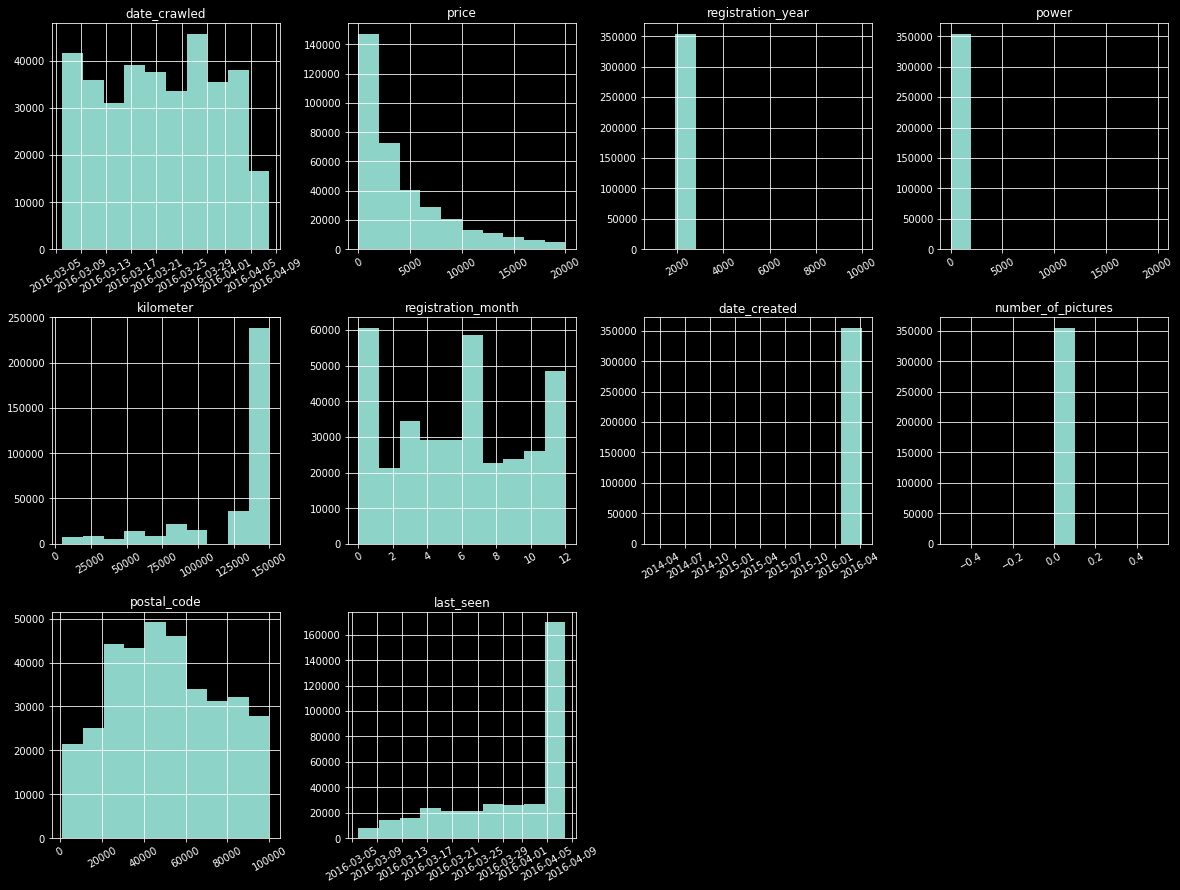

In [8]:
df["date_crawled"] = pd.to_datetime(df["date_crawled"]).round("d")
df["date_created"] = pd.to_datetime(df["date_created"])
df["last_seen"] = pd.to_datetime(df["last_seen"]).round("d")

df.hist(layout=(3, 4), figsize=(20, 15), bins=10, xrot=30)
plt.show()

По полученным графикам хорошо видно, что практически для всех признаков характерно скопление значение у определенных значений.
Это объясняется наличием в данных выбросов и аномалий. 
Кроме того, значения признака `registration_month` выходят за диапазон признака `date_crawled`, что будет учтено при его обработке на следующих шагах. 

Рассмотрим аномалии каждого признака детально. 

### Признак `price` 

Выведем общую информацию по столбцу и построим более детальную гистограмму, ограниченную 75-ым перцентилем.

In [9]:
df["price"].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

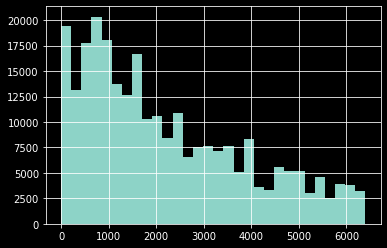

In [10]:
df["price"].hist(range=(0, 6400), bins=30)
plt.show()

В столбце содержится большое количество нулевых значений, которые, скорее всего, связаны с желанием пользователей поднять свои объявления в поисковой выдаче.
Подобные объекты могут повредить обучению моделей и их целесообразно исключить из рассмотрения.
Для это выберем порог по 5-му перцентилю.

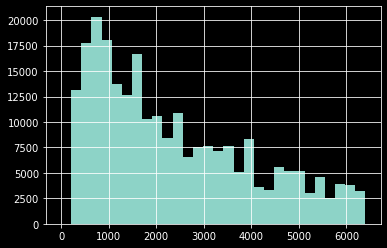

In [11]:
df = df.drop(df[df["price"] <= df["price"].quantile(0.05)].index)
df["price"].hist(range=(0, 6400), bins=30)
plt.show()

Полученное распределение соответствует распределению Пуассона с шумовой составляющей после пика характеристики.

### Признак `registration_year`

Для анализа распределения значений разделим года на категории и соберем сводную таблицу по ним.

In [12]:
def grouped_feature(feature, start, stop, num):
    steps = [-float("inf")]
    for x in np.linspace(start=start, stop=stop, num=num):
        steps.append(int(x))
    steps.append(float("inf"))
    grouped_feature = feature + "_group"
    df[grouped_feature] = pd.cut(df[feature], steps)

    return df.groupby(grouped_feature)["price"].agg(["count", "median", "mean"])

In [13]:
grouped_feature("registration_year", 1940, 2016, 6)

,count,median,mean
registration_year_group,,,
"(-inf, 1940.0]",110,2700.0,5392.690909
"(1940.0, 1955.0]",87,10000.0,10180.402299
"(1955.0, 1970.0]",1141,6890.0,7988.452235
"(1970.0, 1985.0]",4080,4800.0,6049.400735
"(1985.0, 2000.0]",108161,1199.0,1780.382633
"(2000.0, 2016.0]",207765,4899.0,6211.075104
"(2016.0, inf]",13577,2000.0,3372.025042


Из полученной таблицы следует, что основная часть объектов находится в диапазоне от 1970 года и старше.
При этом их средняя стоимость изменяется по нелинейному закону: наибольшее значение характерно для группы раритетных автомобилей, выпущенных в период (1940, 1955] годов; объекты старше стоят в разы меньше, а стоимость более молодых объектов снижается до периода (1985, 2000], после чего опять растет.
Современные автомобили в среднем стоят примерно в два раза дешевле раритетных.

Для построения более робастной модели целесообразно признак года заменить на возраст. 
В этом случае модель можно будет применять и в будущем без доработок.

Примечательно, что в таблице присутствуют объекты из будущего - дата регистрации которых старше даты выгрузки из базы.
Такие значения наряду с очень старыими (старше 100 лет) будем считать выбросами и обработаем их, заменив на значение `-1`.

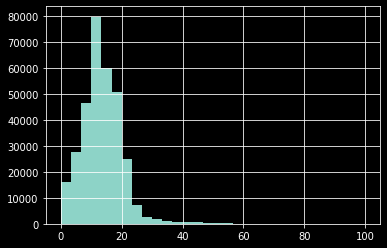

In [14]:
df["age"] = 2016 - df["registration_year"].values
df.loc[(df["age"] < 0) | (df["age"] > 100), "age"] = -1

X.remove("registration_year")
X.append("age")

df["age"].hist(range=(0, 100), bins=30)
plt.show()

После проведенной обработки данные в столбце `age` имеют распределение Пуассона.

### Признак `power`

Выведем общую информацию по столбцу и, аналогично признаку `registration_year`, разделим данные на группы в диапазоне от 50 л.с. (чуть менее 25го перцентиля) до 250 л.с. (современный уровень большинства автомобилей) и построим сводную таблицу.

In [15]:
df["power"].describe()

count    334921.000000
mean        112.413721
std         187.203968
min           0.000000
25%          72.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

In [16]:
grouped_feature("power", 50, 350, 5)

,count,median,mean
power_group,,,
"(-inf, 50.0]",42357,1300.0,2456.297495
"(50.0, 125.0]",175590,2200.0,3415.303599
"(125.0, 200.0]",94675,5500.0,6674.323295
"(200.0, 275.0]",17263,9900.0,10175.484389
"(275.0, 350.0]",3905,10499.0,10550.526504
"(350.0, inf]",1131,10999.0,10242.206897


Из полученных таблиц видно, что средняя цена автомобиля увеличивается с увеличением мощности его двигателя - что логично. 
При этом в данных присутствуют выбросы, которые могут быть связаны с неправильной интерпретацией единиц измерения (кВт или Вт вместо л.с.), опечатками при заполнении соответствующих полей пользователями или техническим сбоем при выгрузке данных из базы.
Выбивающиеся за рамки разумного значения приравняем к `-1`.

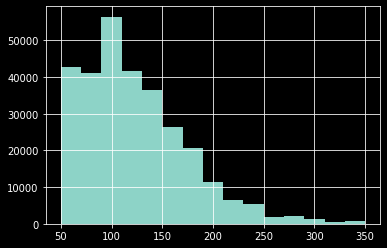

In [17]:
df.loc[(df["power"] < 50) | (df["power"] > 350), "power"] = -1
df["power"].hist(range=(50, 350), bins=15)
plt.show()

Полученное распределение соответствует Пуассоновому с шумовой составляющей, которая объясняется дискретностью характеристики мощности для разных моделей.

### Признак `registration_month`

Построим графики количества автомобилей и средней стоимости в зависимости от месяца их регистрации.

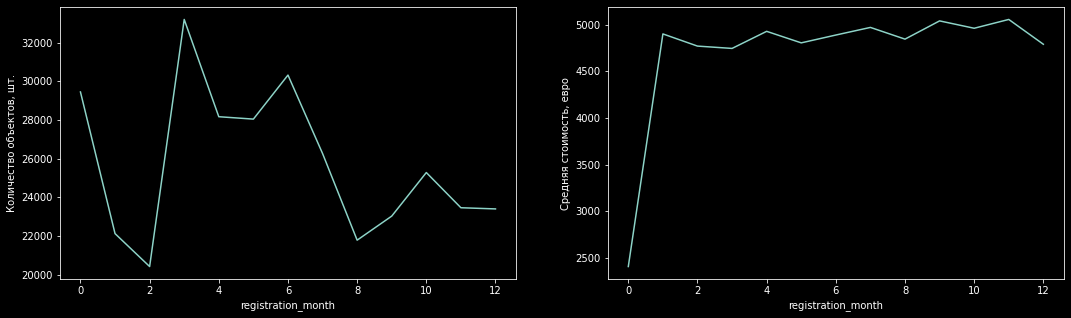

In [18]:
_, axs = plt.subplots(1, 2, figsize=(18, 5))

df.groupby("registration_month")["price"].count().plot(ax=axs[0])
axs[0].set_ylabel("Количество объектов, шт.")
df.groupby("registration_month")["price"].mean().plot(ax=axs[1])
axs[1].set_ylabel("Средняя стоимость, евро")

plt.show()

По графикам хорошо видно, что в данных есть нулевой месяц.
При этом количество объявлений для него не сильно отличается от остальных месяцев, в то время как средняя стоимость автомобелей с таким признаком примерно в 2 раза ниже остальных.
Несмотря на то, что такое значение является аномальным, оставим его без изменений, так как оно явно выделяется на фоне остальных значений и равносильно любой другой отметке об его аномальности. 

По остальным месяцам можно сделать вывод, что большее количество автомобилей продается в весенние и летние месяцы, однако это не влияет на их стоимость.

### Признак `number_of_pictures`

Выведем количество уникальных значений для признака.

In [19]:
df["number_of_pictures"].nunique()

1

Очевидно, что рассматриваемый признак неинформативный.
В этой связи, его можно исключить из списка признаков.

In [20]:
X.remove("number_of_pictures")

### Признак `postal_code`

Выведем количество уникальных значений для признака.

In [21]:
df["postal_code"].nunique() 

8132

Значений достаточно большое количество.
Для их анализа построим графики зависимости цены средней цены объекта от почтового индекса и аналогичной зависимости с осреднением по 1000 значениям (получено имперически).

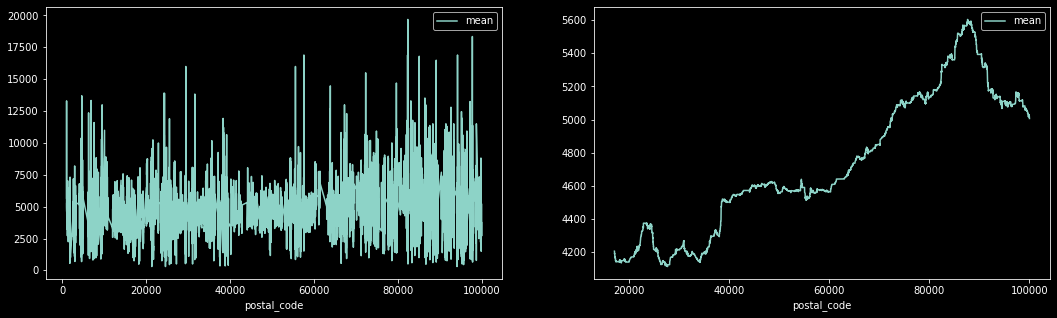

In [22]:
_, axs = plt.subplots(1, 2, figsize=(18, 5))
df.groupby('postal_code')["price"].agg(['mean']).plot(ax=axs[0])
df.groupby('postal_code')["price"].agg(['mean']).rolling(1000).mean().plot(ax=axs[1])
plt.show()

По графикам видно, что есть зависимость цены от почтового индекса или, что то же самое, региона продажи.
При этом эта зависимость проявляется только при осреднении 1000 значений. 
Меньшее осреднение не позволяет выделить тренд от шумамов, а большее становится не информативным.
В этой связи, для повышения качества моделирования, округлим значение признака до 1000.
Учитывая, что данный признак не подлежит количественному измерению, его следует отнести к категориальным при выполнении непосредственного моделирования.

In [23]:
df['postal_code'] = round(df['postal_code'] // 1000, 0)

Проверим количество уникальных значений признака.

In [24]:
df["postal_code"].nunique() 

95

Значение сократилось примерно в 90 раз.

## Категориальные признаки

### Признак `vehicle_type`

Построим сводную таблицу по признаку.

In [25]:
df.groupby(["vehicle_type"], dropna=False)["price"].agg(["count", "median", "mean"])

,count,median,mean
vehicle_type,,,
bus,28183,4350.0,5601.830217
convertible,19763,5500.0,6958.124627
coupe,15376,4250.0,6316.529917
other,2981,2500.0,3926.923516
sedan,88275,3199.0,4891.310700
small,74808,1699.0,2851.434432
suv,11751,8650.0,9196.874309
wagon,62914,3400.0,5053.519535
NaN,30870,1550.0,2874.964723


Из таблицы видно, что в целом, данные соответствуют действительности.
Во-первых, больше всего продаются седаны и малолитражки.
Во-вторых, наиболее дорогие автомобили - это кроссоверы и кабриолеты.
Примечательно, что медиана и среднее значение стоимости отличаются от 5% до 20%, что говорит о больших разбросах по цене разных типов авто.  

В датафрейме около 10% объектов не содержат данных о типе автомобиля. 
Для успешной обработки таких значений различными типами моделей заменим их на строку `other`.

In [26]:
df["vehicle_type"] = df["vehicle_type"].fillna("other")
df["vehicle_type"].isna().sum()

0

### Признак `gearbox`

Построим сводную таблицу по признаку.

In [27]:
df.groupby(["gearbox"], dropna=False)["price"].agg(["count", "median", "mean"])

,count,median,mean
gearbox,,,
auto,64377,5750.0,7044.076145
manual,255270,2600.0,4179.988338
NaN,15274,1700.0,2852.371743


Из таблицы следует, что объявлений авто с ручной коробкой в 4,5 раза больше, но их стоимость в 1,5 меньше.
Такой результат так же соответствует действительности.

Около 5% объектов с пропусками в рассмотренном признаке. Обработаем их аналогичным образом.

In [28]:
df["gearbox"] = df["gearbox"].fillna("other")
df["gearbox"].isna().sum()

0

### Признак `model`

Определим количество уникальных моделей и выведем их полный список, а также количество пропусков в столбце.

In [29]:
df["model"].nunique()

250

In [30]:
df["model"].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'other', 'c4', 'civic',
       'transporter', 'punto', 'e_klasse', 'clio', 'kadett', 'kangoo',
       'one', 'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8',
       'jetta', 'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156',
       'escort', 'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia',
       'combo', 'focus', 'tt', 'corsa', 'a6', 'jazz', 'omega', 'slk',
       '7er', '80', '147', 'z_reihe', 'sportage', 'sorento', 'v40',
       'ibiza', 'mustang', 'eos', 'touran', 'getz', 'a3', 'almera',
       'megane', 'lupo', 'r19', 'zafira', 'caddy', 'mondeo', 'cordoba',
       'colt', 'impreza', 'vectra', 'berlingo', 'tiguan', 'i_reihe',
       'espace', 'sharan', '6_reihe', 'panda', 'up', 'seicento', 'ceed',
       '5_reihe', 'yeti', 'octavia', 'mii', 'rx_reihe', '6er', 'modus',
       'fox'

In [31]:
df["model"].isna().sum()

16364

Из всех 250 различных моделей видны со схожими названиями и их можно оптимизировать, объединив.
Однако это весьма трудозатратно и вряд ли принесет значительный выигрыш при моделировании.
В этой связи, проведем группировку редких моделей, число которых менее 500 во всем датафрейме и присвоим им значение `other`.
Это же значение присвоим и объектам с пропуском.

In [32]:
df["model"] = df["model"].fillna("other")

In [33]:
t = df.groupby(["model"])["model"].agg(["count"])
rare_models = list(t.loc[t["count"] < 500].index)

In [34]:
def model_grouped(raw):
    if raw["model"] in rare_models:
        return "other"
    return raw["model"]

In [35]:
df["model"] = df.apply(model_grouped, axis=1)
df["model"].nunique()

99

В столбце осталось только 99 уникальных значений, что упростит их категоризацию.

### Признак `fuel_type`

Построим сводную таблицу по признаку.

In [36]:
df.groupby(["fuel_type"], dropna=False)["price"].agg(["count", "median", "mean"])

,count,median,mean
fuel_type,,,
cng,547,3900.0,4610.681901
electric,85,5890.0,7046.152941
gasoline,96787,5400.0,6710.891432
hybrid,225,10500.0,9801.324444
lpg,5133,3000.0,4178.641340
other,144,1700.0,3261.256944
petrol,205239,2299.0,3949.444014
NaN,26761,1500.0,2866.761294


Тип топлива `gasoline` и `petrol` являются синонимами и переводятся как бензин.  
в то же время, среди значений в рассматриваемом признаке отсутствует дизельное топливо (diesel), в связи с чем можно считать, что под одним из перечисленных значений подразумевалось как раз дизельное топливо.
По всей видимости, это gasoline, что подтверждается меньшим количеством объектов и их большей средней ценой.  

Пропуски в столбце заменим на имеющееся значение `other`.

In [37]:
df["fuel_type"] = df["fuel_type"].fillna("other")

### Признак `brand`

Анализ распределения значений признака не дал каких-либо новых результатов.
Количество уникальных значений составляет 40.
Дальнейшая группировка их представляется не целесообразной.

In [38]:
df["brand"].nunique()

40

### Признак `not_repaired`

Построим сводную таблицу по признаку.

In [39]:
df.groupby(["not_repaired"], dropna=False)["price"].agg(["count", "median", "mean"])

,count,median,mean
not_repaired,,,
no,242040,3800.0,5408.038399
yes,31276,1100.0,2196.797480
NaN,61605,1700.0,3025.737960


В принципе сложно однозначно сказать, что подразумевает признак. 
Например, значение `yes` читается как: "Да, не ремонтировалась", что должно говорить о более высокой цене объекта.
Однако таких машин меньше во всем датафрейме и их средняя стоимость ниже.

Пропуски в столбце заменим на `other`.

In [40]:
df["not_repaired"] = df["not_repaired"].fillna("other")

## Обработка дубликатов

Проверим количество дубликатов после обработки всех признаков.

In [41]:
df.duplicated().agg(["sum", "mean"])

sum     6922.000000
mean       0.020668
dtype: float64

Количество дубликатов увеличилось в разы по сравнению с начальным значением.
Однако их общее число не превосходит 2%, что позволяет их беспрепятственно удалить.

In [42]:
df = df.drop_duplicates()

## Заключение по EDA

Проведен анализ данных, согласно которому получено, что в датафрейме в большом количестве содержатся аномальные значения и пропуски. 
Такие значения для целевого признака исключены, для числовых признаков заменены на значения `-1`, а для категориальных на `other`.

Рекомендуется обратиться к их источнику для оценки возможности их исправления.

# Машинное обучение

## Подготовка данных

При использовании моделей линейной регрессии и LightGBM необходимо кодирование категориальных признаков.
С этой целью определим список с категориальными признаками и применим соответствующий модуль библиотеки Pandas.
Полученные новые признаки сохраним в соответствующий список.

In [43]:
X_cat = [
    "vehicle_type",
    "gearbox",
    "model",
    "fuel_type",
    "brand",
    "not_repaired"
]

t = pd.get_dummies(df[X_cat])
df = pd.concat([df, t], axis=1)

X_cat_ohe = list(t.columns)
X_ohe = X + X_cat_ohe
for feature in X_cat:
    X_ohe.remove(feature)
    
X_cat_ohe.append('postal_code')

Разделим данные на обучающую и тестовую выборки.

In [44]:
df_train, df_val_test = train_test_split(df, test_size=0.4, random_state=26)
df_val, df_test = train_test_split(df_val_test, test_size=0.5, random_state=26)

In [45]:
len(df_train), len(df_val), len(df_test)

(196799, 65600, 65600)

Обучение нейронными сетями не предполагается, в связи с чем стандартизация числовых признаков не требуется.

## Baseline

Для определения качества разрабатываемых моделей создадим baseline в виде столбца с предсказаниями по среднему значению.

In [46]:
%time dummy_fit = df_train[y].values.mean()
%time df_val["dummy"] = df_train[y].values.mean()
mse_baseline = mean_squared_error(df_val[y], df_val["dummy"], squared=False)
mse_baseline

CPU times: user 2.38 ms, sys: 17 µs, total: 2.39 ms
Wall time: 1.92 ms
CPU times: user 4.36 ms, sys: 16 µs, total: 4.38 ms
Wall time: 4.15 ms


4503.367713187254

Время обучения и предсказания такой упрощенной модели не превосходит 2-5 мс.
Однако точность почти в 2 раза выше установленного порога.

## LightGBM

Определим скорость обучения и предсказания, а также качество предсказания "чистой" модели LightGBM с ненастроенными гиперпараметрами.

In [47]:
model_lgbm_pure = LGBMRegressor(random_state=26, objective="rmse", n_jobs=-1)
%time model_lgbm_pure.fit(df_train[X_ohe], df_train[y], eval_set=(df_val[X_ohe],df_val[y]), verbose=False)

%time df_val['predict_lgbm_pure'] = model_lgbm_pure.predict(df_val[X_ohe])

mse_lgbm_pure = mean_squared_error(
    df_val[y], df_val["predict_lgbm_pure"], squared=False
)
mse_lgbm_pure, (mse_baseline - mse_lgbm_pure) / mse_baseline

CPU times: user 5.57 s, sys: 182 ms, total: 5.75 s
Wall time: 3.25 s
CPU times: user 731 ms, sys: 2.82 ms, total: 734 ms
Wall time: 408 ms


(1761.7008148969612, 0.6088036937916137)

По полученным значениям видно, что время обучения увеличилось на три порядка по сравнению с базовой моделью, а время предсказания увеличилось на два порядка.
При этом значение метрики на 61% лучше той же модели и удовлетворяет заданному порогу в 2500 евро.

Анализ достижимых значений метрики качества требует проведения подбора оптимальных значений гиперпараметров модели.
С этой целью используем функцию RandomizedSearchCV, на вход которой зададим три гиперпараметра: `num_leaves`, `n_estimators`, `learning_rate`.

In [48]:
# Пространство параметров LGBM

space_lgbm = {
    "num_leaves": [int(x) for x in np.linspace(100, 1000, num=20)],
    "n_estimators": [int(x) for x in np.linspace(100, 1000, num=20)],
    "learning_rate": [round(x / 10, 2) for x in np.linspace(1, 10, num=20)],
}

In [49]:
%%time
model_lgbm = RandomizedSearchCV(
    estimator=model_lgbm_pure,
    param_distributions=space_lgbm,
    n_jobs=-1,
    cv=10,
    n_iter=30,
    random_state=26,
)

model_lgbm.fit(df_train[X_ohe], df_train[y])
df_val["predict_lgbm"] = model_lgbm.predict(df_val[X_ohe])
mse_lgbm = mean_squared_error(df_val[y], df_val["predict_lgbm"], squared=False)
mse_lgbm, (mse_lgbm_pure - mse_lgbm) / mse_lgbm_pure

CPU times: user 1min 17s, sys: 5.14 s, total: 1min 22s
Wall time: 1h 26min 17s


(1637.8027975597927, 0.07032863712696592)

Значение метрики качества уменьшилось на 7%.
Для оценки времени обучения и предсказания модели проведем повторное обучение с гиперпараметрами, полученными в ходе их оптимизации.

In [50]:
model_lgbm.best_params_

{'num_leaves': 194, 'n_estimators': 1000, 'learning_rate': 0.19}

In [51]:
model_lgbm_fin = LGBMRegressor(**model_lgbm.best_params_)
%time model_lgbm_fin.fit(df_train[X_ohe], df_train[y])
%time df_val['predict_lgbm_fin'] = model_lgbm_fin.predict(df_val[X_ohe])

CPU times: user 31.8 s, sys: 691 ms, total: 32.5 s
Wall time: 16.8 s
CPU times: user 10.5 s, sys: 27.5 ms, total: 10.5 s
Wall time: 5.43 s


Видно, что время обучения выросло в 5 раз, а время предсказания - в 10 раза.
Учитывая, что требование к качеству предсказания выполняется и на "чистой" модели, улучшение модели LightGBM за счет выбора оптимальных гиперпараметров представляется нецелесообразным.

## Catboost

Проверим скорость и качество предсказания на модели Catboost, у которой из гиперпараметров настроена только скорость обучения для достижения номера лучшей около 900.
Такое условие рекомендовано разработчиками модели Catboost.

In [52]:
meow_pure = CatBoostRegressor(
    random_state=26,
    verbose=100,
    cat_features=X_cat_ohe,
    eval_metric="RMSE",
    learning_rate=0.5,
)
%time meow_pure.fit(df_train[X_ohe], df_train[y], eval_set=(df_val[X_ohe],df_val[y]))

%time df_val['predict_meow_pure'] = meow_pure.predict(df_val[X_ohe])

mse_meow_pure = mean_squared_error(
    df_val[y], df_val["predict_meow_pure"], squared=False
)
mse_meow_pure, (mse_lgbm_pure - mse_meow_pure) / mse_lgbm_pure

0:	learn: 3293.5813338	test: 3294.7989485	best: 3294.7989485 (0)	total: 175ms	remaining: 2m 54s
100:	learn: 1692.8764622	test: 1744.6919046	best: 1744.6919046 (100)	total: 9.03s	remaining: 1m 20s
200:	learn: 1604.8756571	test: 1698.4281843	best: 1698.1996539 (199)	total: 17.2s	remaining: 1m 8s
300:	learn: 1553.7149288	test: 1681.0258270	best: 1681.0258270 (300)	total: 25.3s	remaining: 58.9s
400:	learn: 1516.6318391	test: 1671.9311710	best: 1671.5644989 (385)	total: 33.2s	remaining: 49.7s
500:	learn: 1484.6728988	test: 1665.3195915	best: 1665.3195915 (500)	total: 41s	remaining: 40.8s
600:	learn: 1459.8524866	test: 1663.0503473	best: 1662.7984893 (594)	total: 48.6s	remaining: 32.3s
700:	learn: 1437.7287060	test: 1661.0388208	best: 1660.8394132 (681)	total: 56.9s	remaining: 24.3s
800:	learn: 1417.1827401	test: 1658.5020186	best: 1657.4739061 (768)	total: 1m 4s	remaining: 16.1s
900:	learn: 1398.5975936	test: 1656.2734150	best: 1656.1228810 (893)	total: 1m 12s	remaining: 7.95s
999:	learn: 1

(1654.9633984817847, 0.06058770905513796)

Значение метрики улучшилось на 6% по сравнению с "сырой" моделью LGBM, однако время обучения выросло примерно в 20 раз.
Таким образом, для решения поставленной задачи модель Catboost непригодна.

## Линейная регрессия

Одним из самых быстрых методов машинного обучения является линейная регрессия.
Определим значение метрики качества такой модели для настоящей задачи.

In [53]:
model_lr = LinearRegression()

%time model_lr.fit(df_train[X_ohe], df_train[y])

%time df_val['predict_lr'] = model_lr.predict(df_val[X_ohe])

mse_lr = mean_squared_error(df_val[y], df_val["predict_lr"], squared=False)
mse_lr, (mse_lgbm_pure - mse_lr) / mse_lgbm_pure

CPU times: user 5.31 s, sys: 258 ms, total: 5.57 s
Wall time: 3.14 s
CPU times: user 110 ms, sys: 79.5 ms, total: 190 ms
Wall time: 103 ms


(2804.8658740368187, -0.5921351970316653)

Время обучения модели линейной регрессии практически не отличается от модели LGBM.
В то же время, значение метрики качества ухудшилось на 60%.

Таким образом, модель линейной регрессии непригодна для решения поставленной задачи.

## Проверка на тестовой выборке

В ходе проведенного исследования моделей LightGBM, Catboost и линейной регрессии получено, что на валидационной выборке по совокупности параметров скорости обучения и предсказания, а также его качества лучший результат показала модель LightGBM с гиперпараметрами по умолчанию.
Проведем проверку указанной модели на тестовой выборке. 

In [54]:
df_test['predict_lgbm_pure_test'] = model_lgbm_pure.predict(df_test[X_ohe])

mse_lgbm_pure_test = mean_squared_error(
    df_test[y], df_test["predict_lgbm_pure_test"], squared=False
)
mse_lgbm_pure_test, (mse_lgbm_pure - mse_lgbm_pure_test) / mse_lgbm_pure

(1762.2533819769212, -0.00031365546027309864)

Метрика качества изменилась менее, чем на 1%.

# Выводы

Построена модель для определения рыночной стоимости автомобиля, обеспечивающей оптимальное соотношение качества предсказания, его скорости и времени обучения.
Для оценки качества моделей использовалана метрика RMSE, пороговое значение которой установлено в 2500 евро.

Результаты анализа на валидационной выборке приведены в таблице. 
Учитывая, что время выполнения операции зависит от параметров аппартной части вычислсительного средства, соответствующие характеристики прведены в относительных единицах, где за единицу принято минимальной значение для всех моделей.

|Характеристика|Требование задания|LightGBM (настройки по умолчанию)|LightGBM (настроенные гиперпараметры)|Catboost|LinearRegression|
|:-:|:-:|:-:|:-:|:-:|:-:|
|Время обучения, о.е.|Минимальное    |1,04    |5,4                                 |28,4     |1|
|Время предсказания, о.е.|Минимальное|4|54|22|1|
|Метрика RMSE, евро|2500             |1761 |1637                                 |1654    |2804|

Из таблицы хорошо видно, что модель LightGBM с настройками по умолчанию обладает наилучшими характеристиками по скорости обучения и предсказания по сравнению с остальными моделями.
Учитывая, что эта модель удовлетворяет требованиям по значению метрики качества, она является оптимальной для решения поставленной задачи.

Проверка модели LIghtGBM на тестовой выборке показала, что качество предсказания снижается менее чем на 1% и составляет 1762 евро.